Import libraries

In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import keras
from IPython.display import Audio
from keras import layers
from keras import models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Datasets to be used

In [2]:
#Data Paths

Ravdess = r"D:/CodeAlpha/VoiceRecognition/RAVDESS/audio_speech_actors_01-24/"
Crema = "D:/CodeAlpha/VoiceRecognition/CREMA/AudioWAV/"
Tess = "D:/CodeAlpha/VoiceRecognition/TESS/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "D:/CodeAlpha/VoiceRecognition/SAVEE/ALL/"

1. Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

Video-only (02)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12) - Female (as the actor ID number is even)

In [3]:
#Ravdess
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess +'/'+ dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,D:/CodeAlpha/VoiceRecognition/RAVDESS/audio_sp...
1,neutral,D:/CodeAlpha/VoiceRecognition/RAVDESS/audio_sp...
2,neutral,D:/CodeAlpha/VoiceRecognition/RAVDESS/audio_sp...
3,neutral,D:/CodeAlpha/VoiceRecognition/RAVDESS/audio_sp...
4,calm,D:/CodeAlpha/VoiceRecognition/RAVDESS/audio_sp...


2- Crema-d

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [4]:
#Crema
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())

Emotions
angry      1271
disgust    1271
fear       1271
happy      1271
sad        1271
neutral    1087
Name: count, dtype: int64


In [5]:
Crema_df.head()

,Emotions,Path
0,angry,D:/CodeAlpha/VoiceRecognition/CREMA/AudioWAV/1...
1,disgust,D:/CodeAlpha/VoiceRecognition/CREMA/AudioWAV/1...
2,fear,D:/CodeAlpha/VoiceRecognition/CREMA/AudioWAV/1...
3,happy,D:/CodeAlpha/VoiceRecognition/CREMA/AudioWAV/1...
4,neutral,D:/CodeAlpha/VoiceRecognition/CREMA/AudioWAV/1...


TESS dataset

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

In [6]:
#TESS
tess_directory_list = os.listdir(Tess)

emotion_df = []

for dir in tess_directory_list:
    for wav in os.listdir(os.path.join(Tess, dir)):
        info = wav.partition(".wav")[0].split("_")
        emo = info[2]
        if emo == "ps":
            emotion_df.append(("surprise", os.path.join(Tess, dir, wav)))
        else:
            emotion_df.append((emo, os.path.join(Tess, dir, wav)))


Tess_df = pd.DataFrame.from_dict(emotion_df)
Tess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Tess_df.head()

,Emotion,Path
0,angry,D:/CodeAlpha/VoiceRecognition/TESS/TESS Toront...
1,angry,D:/CodeAlpha/VoiceRecognition/TESS/TESS Toront...
2,angry,D:/CodeAlpha/VoiceRecognition/TESS/TESS Toront...
3,angry,D:/CodeAlpha/VoiceRecognition/TESS/TESS Toront...
4,angry,D:/CodeAlpha/VoiceRecognition/TESS/TESS Toront...


In [7]:
Tess_df.tail()

,Emotion,Path
2795,sad,D:/CodeAlpha/VoiceRecognition/TESS/TESS Toront...
2796,sad,D:/CodeAlpha/VoiceRecognition/TESS/TESS Toront...
2797,sad,D:/CodeAlpha/VoiceRecognition/TESS/TESS Toront...
2798,sad,D:/CodeAlpha/VoiceRecognition/TESS/TESS Toront...
2799,sad,D:/CodeAlpha/VoiceRecognition/TESS/TESS Toront...


Savee dataset
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

'a' = 'anger'
'd' = 'disgust'
'f' = 'fear'
'h' = 'happiness'
'n' = 'neutral'
'sa' = 'sadness'
'su' = 'surprise'

In [8]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,angry,D:/CodeAlpha/VoiceRecognition/SAVEE/ALL/DC_a01...
1,angry,D:/CodeAlpha/VoiceRecognition/SAVEE/ALL/DC_a02...
2,angry,D:/CodeAlpha/VoiceRecognition/SAVEE/ALL/DC_a03...
3,angry,D:/CodeAlpha/VoiceRecognition/SAVEE/ALL/DC_a04...
4,angry,D:/CodeAlpha/VoiceRecognition/SAVEE/ALL/DC_a05...


In [9]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())

Emotions
neutral     120
angry        60
disgust      60
fear         60
happy        60
sad          60
surprise     60
Name: count, dtype: int64


In [10]:
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path,Emotion
0,neutral,D:/CodeAlpha/VoiceRecognition/RAVDESS/audio_sp...,NaN
1,neutral,D:/CodeAlpha/VoiceRecognition/RAVDESS/audio_sp...,NaN
2,neutral,D:/CodeAlpha/VoiceRecognition/RAVDESS/audio_sp...,NaN
3,neutral,D:/CodeAlpha/VoiceRecognition/RAVDESS/audio_sp...,NaN
4,calm,D:/CodeAlpha/VoiceRecognition/RAVDESS/audio_sp...,NaN


Data Visualization

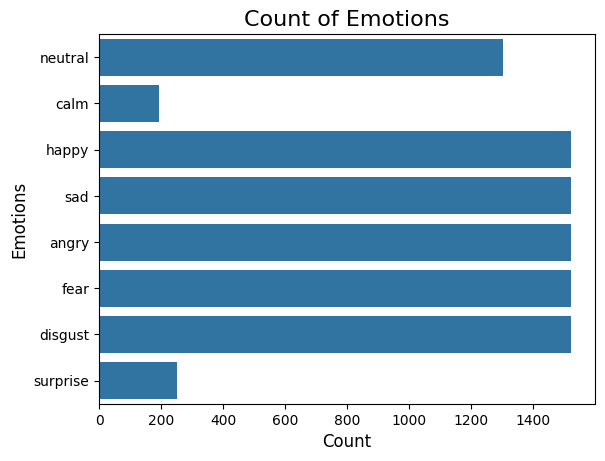

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.xlabel('Count', size=12)
plt.ylabel('Emotions', size=12)
# sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Waveplots - Waveplots let us know the loudness of the audio at a given time.

Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [12]:
import matplotlib.pyplot as plt

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    plt.plot(data)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()


def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [13]:
# Let's concat all datasets together for doing some analysis
df = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)

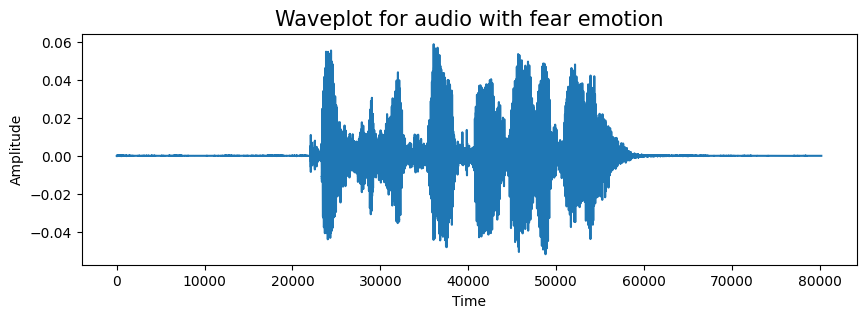

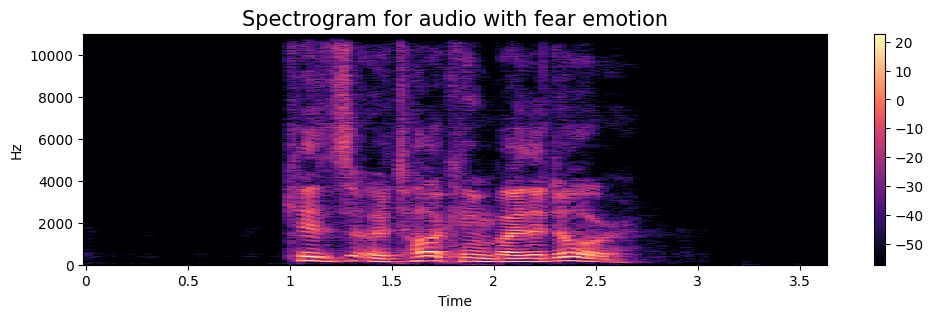

In [14]:
import os
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
if os.path.exists(path):
    # Proceed with loading the file
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
    Audio(path)
else:
    print("File does not exist:", path)

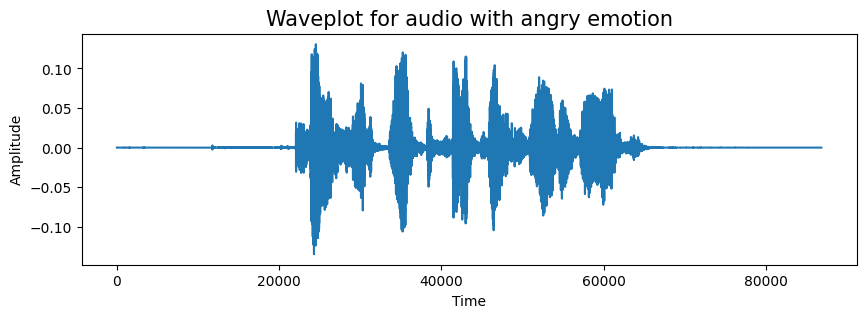

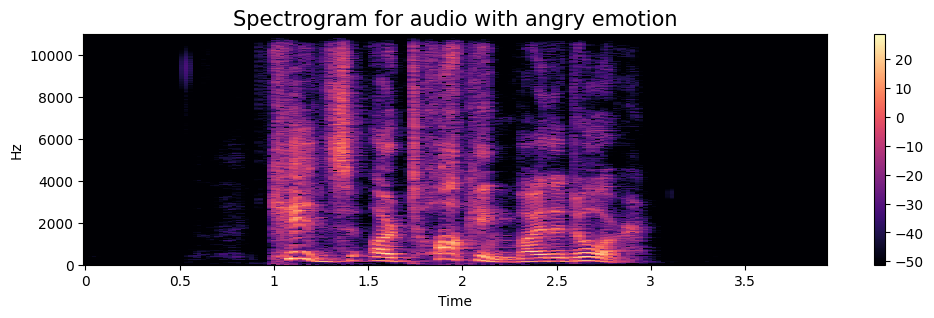

In [15]:
import os
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
if os.path.exists(path):
    # Proceed with loading the file
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
    Audio(path)
else:
    print("File does not exist:", path)

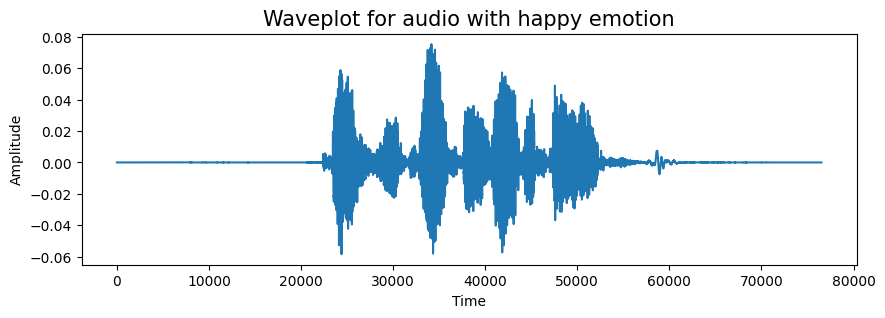

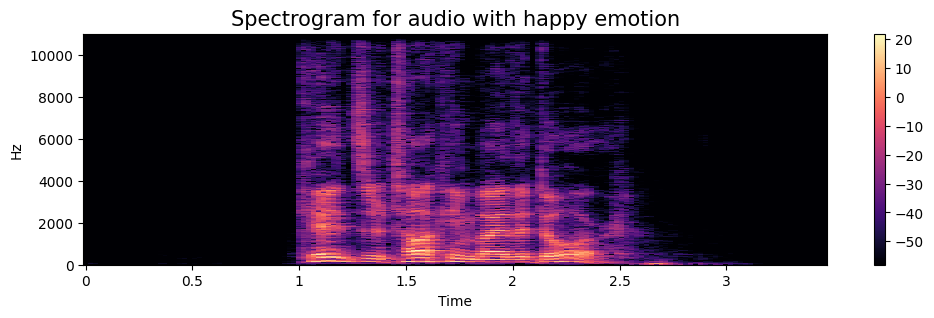

In [16]:
import os
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
if os.path.exists(path):
    # Proceed with loading the file
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
    Audio(path)
else:
    print("File does not exist:", path)

Data Augmentation

Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
In order to this to work adding the perturbations must conserve the same label as the original training sample.

In [17]:
def noise(data, random=False,  threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate)


def shift(data):
    """Shifting data with some rate=1000"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)



In [18]:
# Assuming 'path' contains the path to your audio file
data, sample_rate = librosa.load(path)

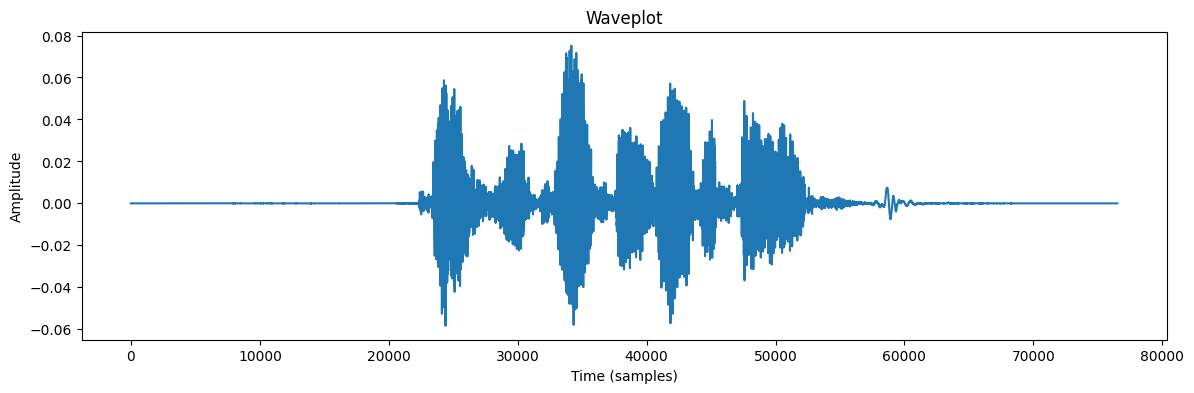

In [19]:
import matplotlib.pyplot as plt



# Plotting the waveplot using matplotlib
plt.figure(figsize=(14, 4))
plt.plot(data)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Waveplot')
plt.show()

# Playing the audio
Audio(path)


Noise data

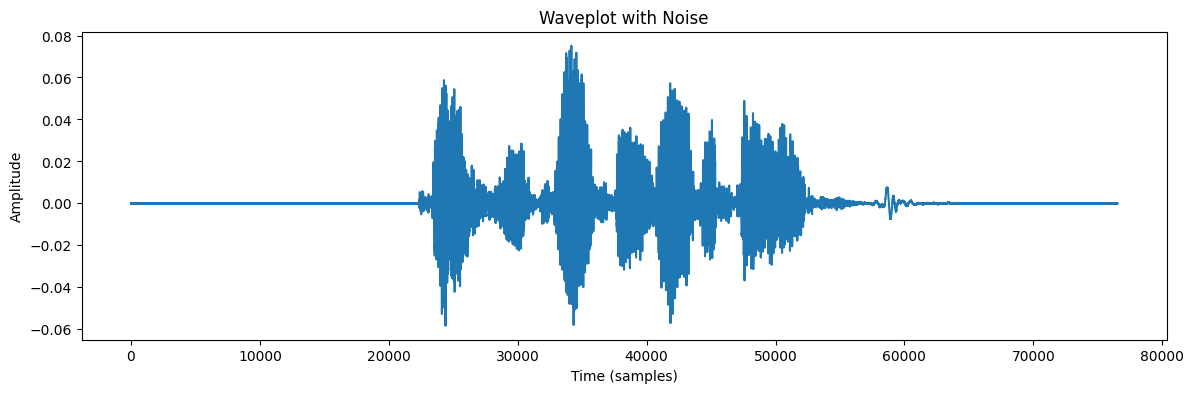

In [20]:

# Adding random noise to the audio data
noised_data = noise(data, random=True)

# Plotting the waveplot of the noised data
plt.figure(figsize=(14, 4))
plt.plot(noised_data)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Waveplot with Noise')
plt.show()

# Playing the audio with noise
Audio(noised_data, rate=sampling_rate)


Shifting

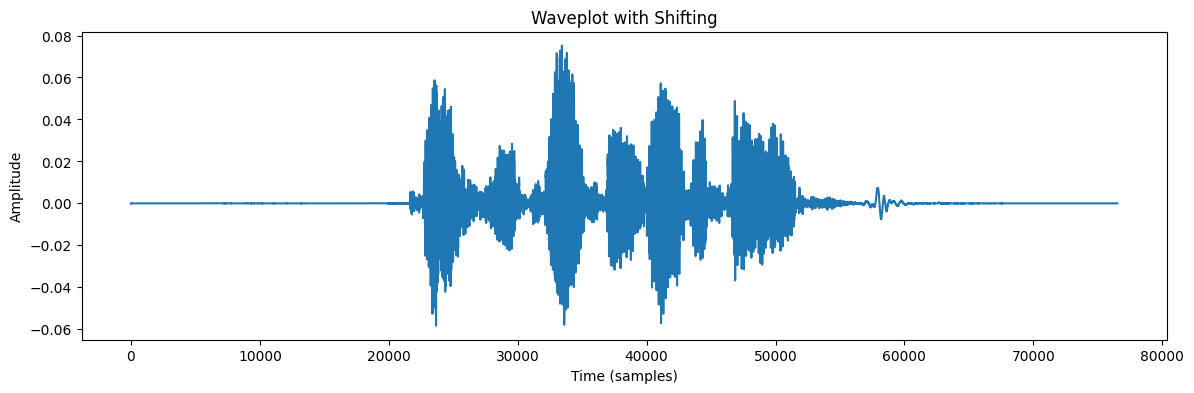

In [21]:

# Shifting the audio data
x = shift(data)

# Plotting the waveplot of the shifted data
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Waveplot with Shifting')
plt.show()

# Playing the shifted audio
Audio(x, rate=sampling_rate)


*Feature extraction*

There are some features may be useful:

Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.

Energy : The sum of squares of the signal values, normalized by the respective frame length.

Entropy of Energy :The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.

Spectral Centroid : The center of gravity of the spectrum.

Spectral Spread : The second central moment of the spectrum.

Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.

Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.

Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.

MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

In [22]:
n_fft = 2048
hop_length = 512

In [23]:
def chunks(data, frame_length, hop_length):
    for i in range(0, len(data), hop_length):
        yield data[i:i+frame_length]

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)


def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length

def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


def entropy_of_energy(data, frame_length=2048, hop_length=512):
    energies = energy(data, frame_length, hop_length)
    energies /= np.sum(energies)

    entropy = 0.0
    entropy -= energies * np.log2(energies)
    return entropy


def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_centroid)

def spc_flux(data):
    isSpectrum = data.ndim == 1
    if isSpectrum:
        data = np.expand_dims(data, axis=1)

    X = np.c_[data[:, 0], data]
    af_Delta_X = np.diff(X, 1, axis=1)
    vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf


def spc_rollof(data, sr, frame_length=2048, hop_length=512):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spcrollof)

def chroma_stft(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.squeeze(chroma_stft.T) if not flatten else np.ravel(chroma_stft.T)


def mel_spc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    return np.squeeze(mel.T) if not flatten else np.ravel(mel.T)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [24]:
path = np.array(data_path["Path"])[658]
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
len(data)


54458

In [25]:
print("ZCR: ", zcr(data).shape)
print("Energy: ", energy(data).shape)
print("Entropy of Energy :", entropy_of_energy(data).shape)
print("RMS :", rmse(data).shape)
print("Spectral Centroid :", spc(data, sampling_rate).shape)
# print("Spectral Entropy: ", spc_entropy(data, sampling_rate).shape)
print("Spectral Flux: ", spc_flux(data).shape)
print("Spectral Rollof: ", spc_rollof(data, sampling_rate).shape)
print("Chroma STFT: ", chroma_stft(data, sampling_rate).shape)
print("MelSpectrogram: ", mel_spc(data, sampling_rate).shape)
print("MFCC: ", mfcc(data, sampling_rate).shape)

ZCR:  (107,)
Energy:  (107,)
Entropy of Energy : (107,)
RMS : (107,)
Spectral Centroid : (107,)
Spectral Flux:  ()
Spectral Rollof:  (107,)
Chroma STFT:  (1284,)
MelSpectrogram:  (13696,)
MFCC:  (2140,)


In [26]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        # np.mean(energy(data, frame_length, hop_length),axis=0),
                        # np.mean(entropy_of_energy(data, frame_length, hop_length), axis=0),
                        rmse(data, frame_length, hop_length),
                        # spc(data, sr, frame_length, hop_length),
                        # spc_entropy(data, sr),
                        # spc_flux(data),
                        # spc_rollof(data, sr, frame_length, hop_length),
                        # chroma_stft(data, sr, frame_length, hop_length),
                        # mel_spc(data, sr, frame_length, hop_length, flatten=True)
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

In [27]:
def get_features(path, duration=2.5, offset=0.6):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with shifting
    shifted_data = shift(data)
    res3 = extract_features(shifted_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with shifting and white_noise
    new_data = shift(data)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [28]:
X, Y = [], []
print("Feature processing...")
for path, emotion, ind in zip(data_path.Path, data_path.Emotion, range(data_path.Path.shape[0])):
    features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
print("Done.")



Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
1500 samples has been processed...
1600 samples has been processed...
1700 samples has been processed...
1800 samples has been processed...
1900 samples has been processed...
2000 samples has been processed...
2100 samples has been processed...
2200 samples has been processed...
2300 samples has been processed...
2400 samples has been processed...
2500 samples has been processed...
2600 samples has been processed...
2700 samples has been processed...
2800 sampl

Adding extracted features in CSV file

In [29]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)


In [30]:
Features.head()


,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.173828,0.264648,0.372559,0.486328,0.625488,0.681152,0.720703,0.651855,0.562988,0.559082,...,0.766315,0.755441,0.743671,0.731043,0.717561,0.703260,0.688124,0.672208,0.655518,NaN
1,0.257324,0.382324,0.509766,0.500000,0.503906,0.496094,0.484375,0.500488,0.500977,0.519043,...,0.720011,2.094777,-1.312607,1.438006,2.455701,0.236823,7.848722,5.726809,-2.563129,NaN
2,0.307129,0.433105,0.567871,0.560547,0.550293,0.558105,0.538574,0.500000,0.434570,0.407715,...,1.562171,1.440917,1.318393,1.196094,1.075361,0.957390,0.843122,0.733403,0.628811,NaN
3,0.254395,0.385742,0.509766,0.514648,0.509766,0.493652,0.489258,0.479492,0.475586,0.480469,...,1.017528,3.659250,3.336699,6.785823,3.796761,1.071989,2.209212,0.134094,2.826355,NaN
4,0.247070,0.389648,0.564941,0.642578,0.665527,0.684570,0.676270,0.666992,0.648926,0.595703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


In [31]:
Features.tail()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
48643,0.029785,0.041016,0.053711,0.049805,0.040527,0.037598,0.035156,0.065430,0.107422,0.121582,...,-0.601935,3.138181,9.078802,9.875224,5.314281,3.130456,5.391706,9.496977,6.258999,NaN
48644,0.000000,0.000000,0.006348,0.016113,0.025879,0.034180,0.036621,0.033691,0.032715,0.032227,...,-4.478354,-5.067346,-4.775791,0.778204,5.260514,-0.345362,-1.215722,8.969276,7.940011,NaN
48645,0.152832,0.229492,0.278809,0.207520,0.145996,0.086914,0.100098,0.127441,0.129395,0.126953,...,-7.814318,-1.554416,-2.823327,-1.735180,-0.381089,1.600315,7.182204,7.859456,-2.545928,NaN
48646,0.011230,0.011230,0.011230,0.005371,0.005859,0.016113,0.025879,0.034180,0.037109,0.033691,...,-12.125244,-15.206301,-5.833350,3.224798,6.293930,-1.113990,0.751525,8.796665,3.645967,NaN
48647,0.168945,0.271484,0.363281,0.385254,0.312988,0.221191,0.140137,0.083008,0.138184,0.161621,...,-13.561117,-9.390510,-5.572158,2.674331,1.991670,-0.557945,1.654136,5.187684,5.740201,NaN


In [32]:
extracted_df = pd.read_csv('./features.csv')
print(extracted_df.shape)

(48648, 2377)


In [33]:
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(48648, 2377)

In [34]:
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.173828,0.264648,0.372559,0.486328,0.625488,0.681152,0.720703,0.651855,0.562988,0.559082,...,0.766315,0.755441,0.743671,0.731043,0.717561,0.703260,0.688124,0.672208,0.655518,0
1,0.257324,0.382324,0.509766,0.500000,0.503906,0.496094,0.484375,0.500488,0.500977,0.519043,...,0.720011,2.094777,-1.312607,1.438006,2.455701,0.236823,7.848722,5.726809,-2.563129,0
2,0.307129,0.433105,0.567871,0.560547,0.550293,0.558105,0.538574,0.500000,0.434570,0.407715,...,1.562171,1.440917,1.318393,1.196094,1.075361,0.957390,0.843122,0.733403,0.628811,0
3,0.254395,0.385742,0.509766,0.514648,0.509766,0.493652,0.489258,0.479492,0.475586,0.480469,...,1.017528,3.659250,3.336699,6.785823,3.796761,1.071989,2.209212,0.134094,2.826355,0
4,0.247070,0.389648,0.564941,0.642578,0.665527,0.684570,0.676270,0.666992,0.648926,0.595703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


Data Preparation

In [35]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [36]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
Y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.3, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34053, 2376), (14595, 2376), (34053, 8), (14595, 8))

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((30647, 2376), (14595, 2376), (3406, 2376), (30647, 8), (14595, 8), (3406, 8))

In [39]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((30647, 2376), (14595, 2376), (3406, 2376), (30647, 8), (14595, 8), (3406, 8))

In [40]:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(30647, 2376, 1)

**Models**

1- CNN

In [41]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [59]:
model = models.Sequential()
model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(X_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(8, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 512)         3072      
                                                                 
 batch_normalization (Batch  (None, 2376, 512)         2048      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 1188, 512)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_1 (Bat  (None, 1188, 512)         2048      
 chNormalization)                                                
                                                        

LSTM

In [44]:
from keras.layers import LSTM

model01=Sequential()
model01.add(LSTM(128,return_sequences=True,input_shape=(X_train.shape[1],1)))
model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.3))
model01.add(LSTM(128))
#model01.add(Dropout(0.3))
model01.add(Dense(8,activation = 'softmax'))
model01.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [45]:
model01.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2376, 128)         66560     
                                                                 
 dropout (Dropout)           (None, 2376, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, 2376, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 2376, 128)         131584    
                                                                 
 lstm_3 (LSTM)               (None, 2376, 128)         131584    
                                                                 
 lstm_4 (LSTM)               (None, 2376, 128)         131584    
                                                                 
 lstm_5 (LSTM)               (None, 2376, 128)        

Evaluation

In [46]:

batch_size = 64

In [47]:
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)


lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)


In [48]:

history=model.fit(X_train, y_train, epochs=1, validation_data=(X_val, y_val), batch_size=batch_size,callbacks=[early_stop,lr_reduction])



479/479 [==============================] - 11457s 24s/step - loss: nan - accuracy: 0.0334 - f1_m: nan - val_loss: nan - val_accuracy: 0.0332 - val_f1_m: nan - lr: 0.0010


In [49]:
y_pred = model.predict(X_test)

457/457 [==============================] - 9867s 22s/step


In [60]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")


457/457 [==============================] - 498s 1s/step - loss: nan - accuracy: 0.0317
Accuracy of our model on test data :  3.172319382429123 %
